In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [3]:
print(f'training_data:\n{train_data}')
print(f'test_data:\n{test_data}')

training_data:
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data:
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
print(f'training_data data shape: {train_data.data.shape}')
print(f'training_data targets shape: {train_data.targets.shape}')
print(f'test_data data shape: {test_data.data.shape}')
print(f'test_data targets shape: {test_data.targets.shape}')

training_data data shape: torch.Size([60000, 28, 28])
training_data targets shape: torch.Size([60000])
test_data data shape: torch.Size([10000, 28, 28])
test_data targets shape: torch.Size([10000])


In [5]:
from torch.utils.data import DataLoader

loaders = {

    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),

}

In [6]:
print(loaders)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x72fcd02455e0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x72fcd029e390>}


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [9]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')

def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct /len(loaders["test"].dataset):.0f}%\f)\n')

In [10]:
for epoch in range(1, 11):
    train(epoch)
    test()

/tmp/ipykernel_78732/599564851.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.302471
Train Epoch: 1 [2000/60000 (3%)]	2.293704
Train Epoch: 1 [4000/60000 (7%)]	2.167045
Train Epoch: 1 [6000/60000 (10%)]	2.013592
Train Epoch: 1 [8000/60000 (13%)]	1.921172
Train Epoch: 1 [10000/60000 (17%)]	1.813292
Train Epoch: 1 [12000/60000 (20%)]	1.773293
Train Epoch: 1 [14000/60000 (23%)]	1.756521
Train Epoch: 1 [16000/60000 (27%)]	1.779469
Train Epoch: 1 [18000/60000 (30%)]	1.731945
Train Epoch: 1 [20000/60000 (33%)]	1.722484
Train Epoch: 1 [22000/60000 (37%)]	1.697890
Train Epoch: 1 [24000/60000 (40%)]	1.688562
Train Epoch: 1 [26000/60000 (43%)]	1.671321
Train Epoch: 1 [28000/60000 (47%)]	1.701394
Train Epoch: 1 [30000/60000 (50%)]	1.644233
Train Epoch: 1 [32000/60000 (53%)]	1.605002
Train Epoch: 1 [34000/60000 (57%)]	1.714235
Train Epoch: 1 [36000/60000 (60%)]	1.633261
Train Epoch: 1 [38000/60000 (63%)]	1.607833
Train Epoch: 1 [40000/60000 (67%)]	1.639500
Train Epoch: 1 [42000/60000 (70%)]	1.573329
Train Epoch: 1 [44000/60000 (73%)]	1.652787

Prediction: 0


/tmp/ipykernel_78732/599564851.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


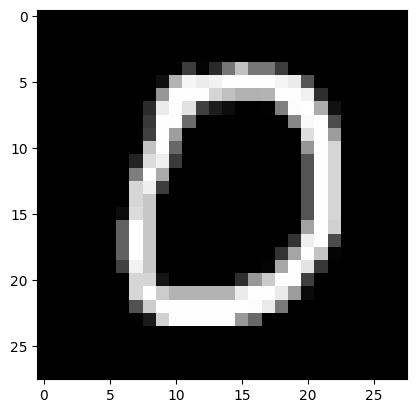

In [13]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[10]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

In [14]:
torch.save(model, 'mnist.pt')